# day 274,day 279

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
import os,zipfile, requests
from PIL import Image

# where to download the transfer learning models from?

1. torch docs -
2. sota (state of the art)
3. hugging face.

# download the model from github

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1244/1244), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 4056 (delta 1078), reused 1092 (delta 999), pack-reused 2812
Receiving objects: 100% (4056/4056), 651.60 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# download the data

In [ ]:
data_path = Path('data')

image_path = data_path / 'images'

image_path.mkdir(parents=True,exist_ok=True)

with open(Path(data_path / 'pizza_steak_sushi.zip'),'wb') as f:
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip').content
  f.write(response)

with zipfile.ZipFile(Path(data_path / 'pizza_steak_sushi.zip'),'r') as zip:
  zip.extractall(image_path)
  zip.close()

# creating the dataloader:

## goals:
1. to do the transform(augmentation) get the normalizing numbers from imagenet. This we do because we want our model to have the same normalized values that the model trained with imagenet has.
2. import data setup from going modular
3. create the transforms
4. get train_dataloader,test_dataloader,class_names from data_setup.create_dataloader function.


In [ ]:
# import data setup from going modular
from going_modular.going_modular import data_setup

# creating the transforms:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([64,64]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

])

# get train_dataloader and test_dataloader and class_names
train_dir = 'data/images/train'
test_dir = 'data/images/test'

train_dataloader, test_dataloader, class_names = \
data_setup.create_dataloaders(train_dir,
                              test_dir,
                              transforms,
                              batch_size=32,
                              num_workers=os.cpu_count())



# why automatic transform?

* when we manually create all the transform functions we may mistakenly morph the data into the form that is not similar to the kind of data the the pretrained model that we download from internet was trained on, automatic transform takes care of this issue for us.



## goals:
1. get the auto transforms of the efficient net b0 model.
2. get the train_dataloader,test_dataloader,class_names from data_setup again but this time with auto_transforms.

In [ ]:
# getting the auto transforms:
auto_transforms = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()

# recreating the train,test dataloaders and class_names
train_dir = 'data/images/train'
test_dir = 'data/images/test'

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    auto_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)

# tangent:

* in self-driving cars the processing of the model happens on the device itself(on the car), there's no uploading to a server and waiting for the server to respond back because lives of those who are on board are at stake here.
* so, this is the reason why a micro computer like your arduino board can't handle the processing unless it has a voluminous RAM and GPU capacity. hence the need for bigger on-device computing processors.

# build the EfficientNet_B3 model to train our data

## goals:
1. get the pretrained weights of the model
2. get the model

In [ ]:
!pip install --force-reinstall torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# base_model
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model = torchvision.models.efficientnet_b3(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:02<00:00, 19.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
from torchinfo import summary

summary(model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    1,080                True
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    80                   True
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 24, 112,

# exploration, analysis and freethrows

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

# modifying only the output layer in feature extractor
* we are going to modify only the classifier layers in the feature_extractor as per the requirement of our custom data.
* we freeze all the layers of our feature extractor such that pre-trained weights of the model remain intact but we only modify the output layer of the model to fit on our custom-data.
* this makes the feature extractor only partially trianable.


## explanations about what is going on:
* accessing each parameter of each layer and making it non-updatable by keeping its gradients un-trainable.
* dropout function drops few neurons randomly to regualarize the model so that the remaining neurons will try to learn the pattern better increasing the model's generalizability. the 'p' hyperparameter in drop out determines the proportion of neurons to drop out. 'in_place' determines whether to carry out the function in the same memory space or do the operation and copy the changes to a new memory space increasing the space requirement. if in-place is set to True then we save up a lot of computational real-estate.
* import the engine from going_modular folder

Arguments of the engine are:


    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").


    

In [ ]:
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model = torchvision.models.efficientnet_b3(weights=weights)

# freezing all the layers by setting the gradient non-updatable
for param in model.features.parameters():
  param.requires_grad = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# updating the output layer of our model to the custom-data we have(pizza_steak_sushi)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1536,#20% of neurons in this 1536 layers will be dropped out
                    out_features=len(class_names))).to(device)


# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)


# train the model with customized engine
from going_modular.going_modular import engine
import time

def total_time(start,end):
  total = end-start
  print("Total Running Time is: {} seconds".format(total))
start_time = time.perf_counter()

history = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       loss_fn = loss,
                       optimizer = optimizer,
                       epochs = 5,
                       device=device)

end_time = time.perf_counter()
total_time(start_time,end_time)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5229 | train_acc: 0.8021 | test_loss: 0.1555 | test_acc: 0.9597
Epoch: 2 | train_loss: 0.2492 | train_acc: 0.9104 | test_loss: 0.1352 | test_acc: 0.9693
Epoch: 3 | train_loss: 0.1674 | train_acc: 0.9333 | test_loss: 0.1767 | test_acc: 0.9540
Epoch: 4 | train_loss: 0.1829 | train_acc: 0.9333 | test_loss: 0.1736 | test_acc: 0.9352
Epoch: 5 | train_loss: 0.3521 | train_acc: 0.8896 | test_loss: 0.1599 | test_acc: 0.9506
Total Running Time is: 33.96865758199988


# exploration,analysis and freethrows

In [ ]:
# the pre-trained weights of the model
for param in model.features.parameters():
  print(param)

Streaming output truncated to the last 5000 lines.
         1.9322e-01, -4.6582e-01, -1.8705e-01, -2.2500e+00, -2.1071e+00,
        -3.1829e-02,  9.1964e-01,  1.1994e-01,  5.2235e-01, -1.0441e-01,
        -6.7640e-01, -1.0051e+00,  2.0287e-02, -6.5179e-01,  5.7035e-03,
        -2.6310e+00, -6.2680e-01, -2.5586e-01,  4.3240e-01,  4.2262e-01,
         2.3858e-01, -5.8377e-02, -5.2871e-01, -1.1253e+00, -1.6892e+00,
        -2.0453e-01,  7.2395e-03,  5.0672e-01,  6.6922e-01, -4.3628e-01,
        -1.8750e+00,  4.2453e-01, -1.3857e+00,  7.7888e-01, -4.3703e-02,
         1.9989e-01, -1.4107e+00, -1.0428e+00, -4.2646e-01, -9.2560e-01,
        -2.7500e+00, -6.3893e-01,  6.1020e-02,  9.5423e-01,  3.4680e-01,
         2.5135e-01,  8.6333e-01,  1.0875e-01,  3.7367e-01, -1.5534e+00,
        -8.5973e-01, -2.8038e-01, -1.5793e-01, -9.8998e-01,  5.5040e-01,
        -2.2262e+00, -3.8782e-01,  2.7847e-01, -8.5268e-01, -7.4367e-01,
         1.2745e+00, -3.1678e-01,  2.9075e-02, -3.0057e-01, -5.6021e-01,


In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1536, out_features=3, bias=True)
)

In [ ]:
from torchinfo import summary

summary(model,
        input_size=(1,3,300,300),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 300, 300]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 300, 300]     [1, 1536, 10, 10]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 300, 300]     [1, 40, 150, 150]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 300, 300]     [1, 40, 150, 150]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 150, 150]    [1, 40, 150, 150]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 150, 150]    [1, 40, 150, 150]    --                   --
│    └─Sequential (1)                                        [1, 40, 150, 150]    [1, 2

In [ ]:
history

{'train_loss': [0.49526420831680296,
  0.18076427206397055,
  0.20648992558320364,
  0.320786664634943,
  0.3810739864905675],
 'train_acc': [0.8208333333333333,
  0.9270833333333334,
  0.8958333333333334,
  0.8541666666666666,
  0.86875],
 'test_loss': [0.16085544154047965,
  0.12028215192258358,
  0.13532134369015694,
  0.20134337544441222,
  0.1804148495197296],
 'test_acc': [0.9289772727272727,
  0.9630681818181819,
  0.9625,
  0.9136363636363637,
  0.94375]}

In [ ]:
history['train_loss']

[0.5229368338982264,
 0.2492267350355784,
 0.16735412379105885,
 0.18287769109010696,
 0.35208743636806805]

# tangent:

* Regularization is a technique used for preventing overfitting.
* Dropout is a technique of Regularization that randomly drops few neurons in the layers such that the remaining neurons in the layers would reduce the overfitting effect and become more accurate in making predictions and thus become more generalizable.

# plotting the history

<Axes: >

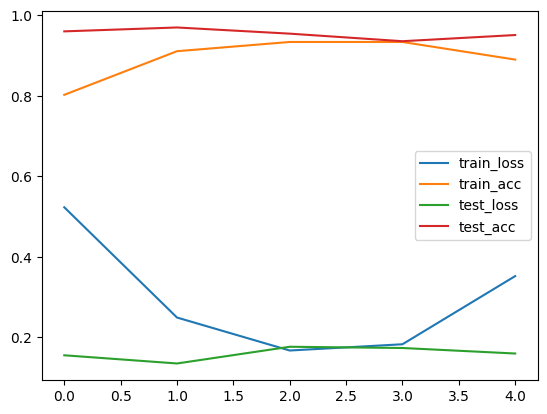

In [ ]:
df = pd.DataFrame(history)
df.plot()

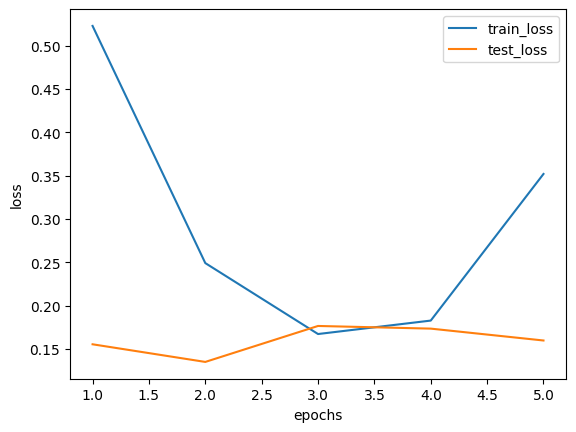

In [ ]:
plt.plot(np.arange(1,len(history['train_loss'])+1),history['train_loss'],label='train_loss')
plt.plot(np.arange(1,len(history['test_loss'])+1),history['test_loss'],label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()

plt.show()

# making prediction with our test data


## goals:
1. access images from test_dir and choose 9 images randomly for the model to predict on.
2. convert them into PIL images. transform their size, shape, datatype and device
3. pass them into the model
4. get their labels and pred_probs(using torch.softmax).
5. plot them on maplotlib with title being the predicted_class_names and predicted probabilities.

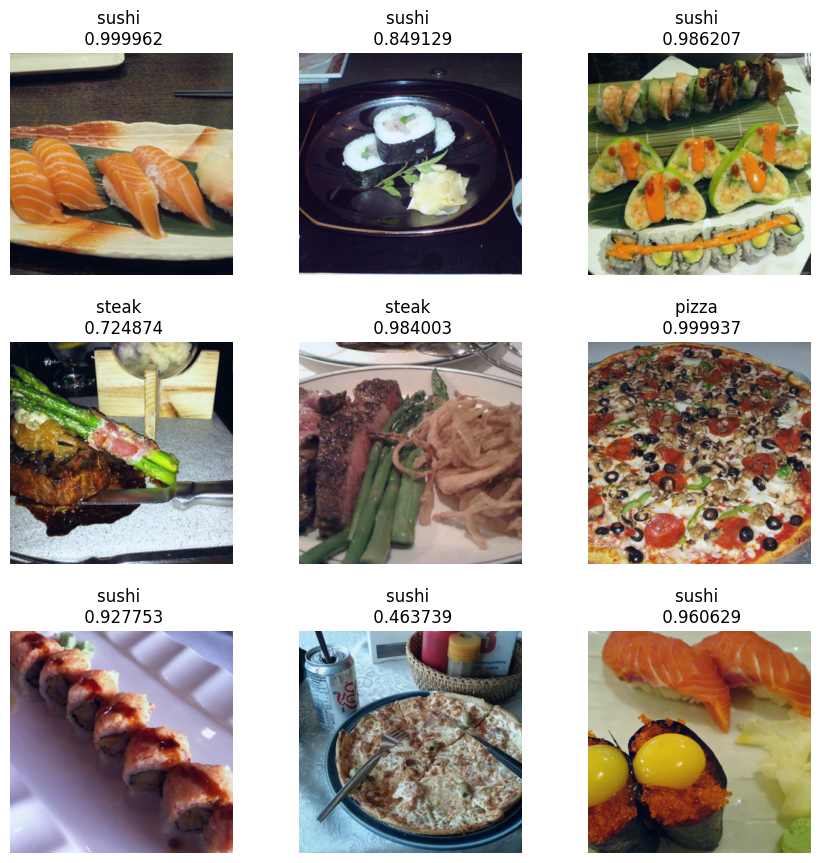

In [ ]:
# getting 9 random images from test_dir
image_paths = np.random.choice(list(Path(test_dir).glob('*/*.jpg')),9)

# transform its size,shape and datatype and device to suit the model
auto_transform = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()

# adjusting the plots
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i,image_path in enumerate(image_paths):

  # get the image
  image = Image.open(image_path)

  # apply augmentation(auto transform)
  image = auto_transform(image)

  # add an extra dimension for the batch for the model to accept
  image = torch.unsqueeze(image,dim=0)

  # put the image in the same device as the model was trained in
  image = image.to(device)

  # prediction
  model.eval()
  with torch.inference_mode():
    pred = model(image).argmax(dim=1)
    pred_prob = torch.max(torch.softmax(model(image),dim=1))

  # plotting them all
  plt.subplot(3,3,i+1)
  image = image.squeeze(dim=0)

  # normalizing or min-max scaling to get the values between 0 and 1.
  min = torch.min(image)
  max = torch.max(image)

  scaled_image = image/max

  if min != max:
    image = (image - min)/(max-min)
  else:
    image = scaled_image
  plt.imshow(image.permute(1,2,0).to('cpu'))
  plt.title('{} \n {:3f}'.format(class_names[pred],pred_prob))
  plt.axis('off')

plt.show()





# exploration,analysis and freethrows

In [ ]:
np.random.choice(list(Path(test_dir).glob('*/*.jpg')),9)

array([PosixPath('data/images/test/pizza/419962.jpg'),
       PosixPath('data/images/test/pizza/419962.jpg'),
       PosixPath('data/images/test/steak/2752603.jpg'),
       PosixPath('data/images/test/pizza/724290.jpg'),
       PosixPath('data/images/test/sushi/2012780.jpg'),
       PosixPath('data/images/test/pizza/441659.jpg'),
       PosixPath('data/images/test/sushi/3834718.jpg'),
       PosixPath('data/images/test/pizza/833711.jpg'),
       PosixPath('data/images/test/sushi/301603.jpg')], dtype=object)

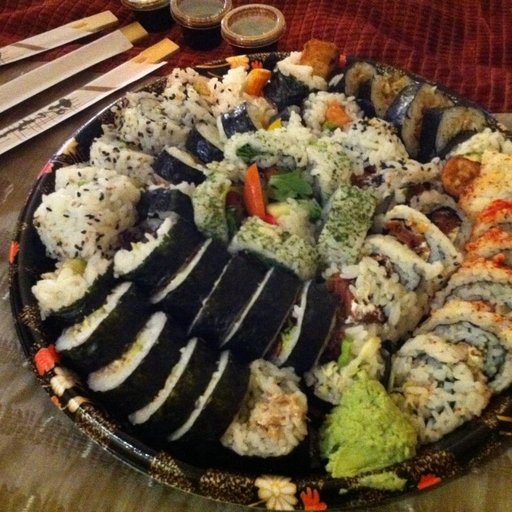

In [ ]:
Image.open(image_paths[0])

In [ ]:
auto_transforms = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()
kundi = auto_transforms(Image.open(image_paths[0]))
kundi

tensor([[[-1.7069, -1.7925, -1.7240,  ..., -1.7412, -1.7412, -1.7069],
         [-1.6727, -1.7583, -1.7754,  ..., -1.5870, -1.5699, -1.5357],
         [-1.6042, -1.6727, -1.7583,  ..., -1.3815, -1.3644, -1.3130],
         ...,
         [-1.1247, -1.1247, -1.1418,  ..., -1.4672, -1.5699, -1.5870],
         [-1.1932, -1.1589, -1.1075,  ..., -1.4329, -1.5185, -1.6042],
         [-1.1589, -1.1760, -1.1589,  ..., -1.5528, -1.6727, -1.6042]],

        [[-0.9678, -1.0728, -1.0728,  ..., -1.6681, -1.6506, -1.6155],
         [-0.8978, -1.0203, -1.0903,  ..., -1.4755, -1.4580, -1.4230],
         [-0.8627, -0.9678, -1.0903,  ..., -1.2479, -1.2129, -1.1779],
         ...,
         [-1.3179, -1.3354, -1.3354,  ..., -1.1604, -1.2654, -1.3354],
         [-1.3704, -1.3529, -1.3004,  ..., -1.1429, -1.2479, -1.3354],
         [-1.3354, -1.3529, -1.3354,  ..., -1.2479, -1.3880, -1.3354]],

        [[-1.5604, -1.6476, -1.6302,  ..., -1.6476, -1.6302, -1.5953],
         [-1.4907, -1.5953, -1.5953,  ..., -1

In [ ]:
kundi.shape,kundi.dtype

(torch.Size([3, 300, 300]), torch.float32)

In [ ]:
list(iter(test_dataloader))[0][0].shape

torch.Size([32, 3, 300, 300])

In [ ]:
torch.unsqueeze(kundi,dim=0).shape

torch.Size([1, 3, 300, 300])

In [ ]:
torch.unsqueeze(kundi,dim=0).squeeze(dim=0).shape

torch.Size([3, 300, 300])

In [ ]:
torch.argmax(model(torch.unsqueeze(kundi,dim=0).to(device)),dim=1)

tensor([2], device='cuda:0')

In [ ]:
torch.max(torch.softmax(model(torch.unsqueeze(kundi,dim=0).to(device)),dim=1))

torch.Size([])

In [ ]:
torch.max(kundi)

tensor(2.3437)

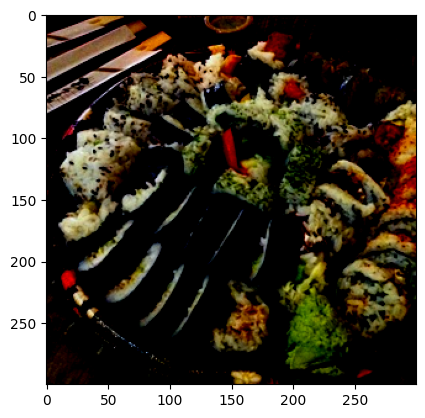

In [ ]:
kundi = kundi/torch.max(kundi)
plt.imshow(kundi.permute(1,2,0));

In [ ]:
kundi

tensor([[[-0.2461, -0.3264, -0.2753,  ..., -0.2461, -0.2461, -0.2972],
         [-0.3191, -0.3630, -0.3264,  ..., -0.2241, -0.2534, -0.3118],
         [-0.3703, -0.3849, -0.3995,  ..., -0.2022, -0.2387, -0.2972],
         ...,
         [ 0.0243,  0.0754,  0.0974,  ..., -0.1291, -0.1365, -0.1730],
         [ 0.0608,  0.0462,  0.0097,  ..., -0.0926, -0.1365, -0.1218],
         [ 0.0389,  0.0097, -0.0634,  ..., -0.0853, -0.1291, -0.1218]],

        [[-0.6968, -0.7416, -0.7043,  ..., -0.6818, -0.6818, -0.7341],
         [-0.7267, -0.7491, -0.7192,  ..., -0.6594, -0.7043, -0.7640],
         [-0.7565, -0.7565, -0.7790,  ..., -0.6370, -0.6818, -0.7416],
         ...,
         [-0.1590, -0.0992, -0.0544,  ..., -0.2710, -0.2710, -0.3009],
         [-0.1365, -0.1440, -0.1664,  ..., -0.2486, -0.2859, -0.2635],
         [-0.1590, -0.1739, -0.2411,  ..., -0.2486, -0.2859, -0.2561]],

        [[-0.6509, -0.7104, -0.6584,  ..., -0.5989, -0.5840, -0.6361],
         [-0.6881, -0.6955, -0.6732,  ..., -0

In [ ]:
auto_transforms = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()
kundi = auto_transforms(Image.open(image_paths[0]))
kundi

tensor([[[-1.7069, -1.7925, -1.7240,  ..., -1.7412, -1.7412, -1.7069],
         [-1.6727, -1.7583, -1.7754,  ..., -1.5870, -1.5699, -1.5357],
         [-1.6042, -1.6727, -1.7583,  ..., -1.3815, -1.3644, -1.3130],
         ...,
         [-1.1247, -1.1247, -1.1418,  ..., -1.4672, -1.5699, -1.5870],
         [-1.1932, -1.1589, -1.1075,  ..., -1.4329, -1.5185, -1.6042],
         [-1.1589, -1.1760, -1.1589,  ..., -1.5528, -1.6727, -1.6042]],

        [[-0.9678, -1.0728, -1.0728,  ..., -1.6681, -1.6506, -1.6155],
         [-0.8978, -1.0203, -1.0903,  ..., -1.4755, -1.4580, -1.4230],
         [-0.8627, -0.9678, -1.0903,  ..., -1.2479, -1.2129, -1.1779],
         ...,
         [-1.3179, -1.3354, -1.3354,  ..., -1.1604, -1.2654, -1.3354],
         [-1.3704, -1.3529, -1.3004,  ..., -1.1429, -1.2479, -1.3354],
         [-1.3354, -1.3529, -1.3354,  ..., -1.2479, -1.3880, -1.3354]],

        [[-1.5604, -1.6476, -1.6302,  ..., -1.6476, -1.6302, -1.5953],
         [-1.4907, -1.5953, -1.5953,  ..., -1

In [ ]:
# min_max scaling to get the kundi to have values only between 0 and 1
min = torch.min(kundi)
max = torch.max(kundi)

# normal normalization
kundi_normalized = kundi / max

if min != max:
  kundi = (kundi - min)/(max-min)

else:
  kundi = kundi_normalized

kundi



tensor([[[0.0911, 0.0721, 0.0873,  ..., 0.0835, 0.0835, 0.0911],
         [0.0986, 0.0797, 0.0759,  ..., 0.1176, 0.1214, 0.1290],
         [0.1138, 0.0986, 0.0797,  ..., 0.1631, 0.1669, 0.1783],
         ...,
         [0.2200, 0.2200, 0.2162,  ..., 0.1442, 0.1214, 0.1176],
         [0.2049, 0.2125, 0.2238,  ..., 0.1518, 0.1328, 0.1138],
         [0.2125, 0.2087, 0.2125,  ..., 0.1252, 0.0986, 0.1138]],

        [[0.2548, 0.2315, 0.2315,  ..., 0.0997, 0.1035, 0.1113],
         [0.2703, 0.2432, 0.2276,  ..., 0.1423, 0.1462, 0.1540],
         [0.2781, 0.2548, 0.2276,  ..., 0.1927, 0.2005, 0.2083],
         ...,
         [0.1772, 0.1733, 0.1733,  ..., 0.2121, 0.1889, 0.1733],
         [0.1656, 0.1695, 0.1811,  ..., 0.2160, 0.1927, 0.1733],
         [0.1733, 0.1695, 0.1733,  ..., 0.1927, 0.1617, 0.1733]],

        [[0.1235, 0.1042, 0.1081,  ..., 0.1042, 0.1081, 0.1158],
         [0.1389, 0.1158, 0.1158,  ..., 0.1467, 0.1505, 0.1583],
         [0.1583, 0.1389, 0.1196,  ..., 0.1930, 0.2007, 0.

# get an image from the internet and predict on it

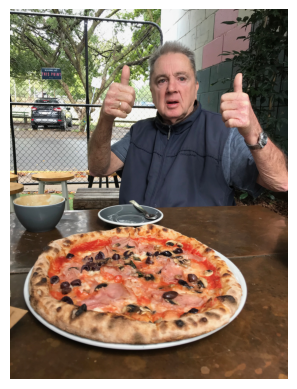

In [ ]:
url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg'
with open(Path('image'), 'wb') as f:
  response = requests.get(url).content
  f.write(response)

image = Image.open('image')
plt.imshow(image)
plt.axis('off');


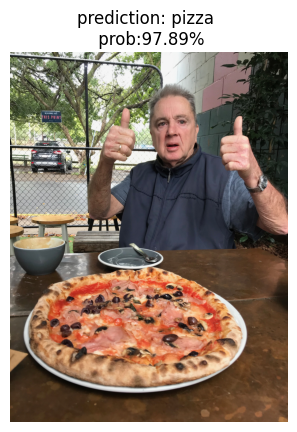

In [ ]:
autotransform = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()

image = Image.open('image')

model_image = autotransform(image).to(device)
model_image = torch.unsqueeze(model_image,dim=0)

# prediction
model.eval()
with torch.inference_mode():
  logits = model(model_image)
  prediction = logits.argmax(dim=1)
  pred_prob = torch.softmax(logits,dim=1).max()


plt.imshow(image)
plt.axis('off')
plt.title('prediction: {} \n prob:{:.2f}%'.format(class_names[prediction],pred_prob*100))
plt.show()

# conclusion:
* the model is not performing that good as far as i can say!!!
* perhaps we have to change the data set it has been trained with.